In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
# append fast.ai local folder to system path so modules can be imported
sys.path.append('/home/paperspace/fastai/')
# automatically reload updated sub-modules
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.structured import *
from fastai.column_data import *

In [3]:
PATH = '~/data/avito-demand-prediction/'

### Data Preparation
Loading and transforming data as required for fast.ai model

In [4]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

In [5]:
# get features from date value
add_datepart(df_train, 'activation_date', drop=False)
add_datepart(df_test, 'activation_date', drop=False)

# select relevant variables
vars_cont = ['price','item_seq_number','deal_probability']
vars_cat = ['region','city','parent_category_name','category_name',
            'user_type','image_top_1','param_1','param_2','param_3',
            'activation_Year','activation_Month','activation_Week',
            'activation_Day','activation_Dayofweek','activation_Dayofyear']
vars_other = ['item_id','user_id','image','title','description']

# only keep these vars for now
df_train = df_train[vars_cat + vars_cont]
for v in vars_cat: df_train[v] = df_train[v].astype('category').cat.as_ordered()
for v in vars_cont: df_train[v] = df_train[v].astype('float32')

# same process on test dataset
df_test = df_test[vars_cat + vars_cont[0:-1]]
for v in vars_cat: df_test[v] = df_test[v].astype('category').cat.as_ordered()
for v in vars_cont[0:1]: df_test[v] = df_test[v].astype('float32')
# in test set, y var needs to be set to zero manually
df_test['deal_probability'] = 0

## combine train and test
#df = pd.concat([df_train, df_test])
## only keep these vars for now
#df = df[vars_cat + vars_cont]

In [6]:
df_train.head()

,region,city,parent_category_name,category_name,user_type,image_top_1,param_1,param_2,param_3,activation_Year,activation_Month,activation_Week,activation_Day,activation_Dayofweek,activation_Dayofyear,price,item_seq_number,deal_probability
0,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Private,1008.0,Постельные принадлежности,NaN,NaN,2017,3,13,28,1,87,400.0,2.0,0.12789
1,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Private,692.0,Другое,NaN,NaN,2017,3,12,26,6,85,3000.0,19.0,0.00000
2,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,Private,3032.0,"Видео, DVD и Blu-ray плееры",NaN,NaN,2017,3,12,20,0,79,4000.0,9.0,0.43177
3,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Company,796.0,Автомобильные кресла,NaN,NaN,2017,3,12,25,5,84,2200.0,286.0,0.80323
4,Волгоградская область,Волгоград,Транспорт,Автомобили,Private,2264.0,С пробегом,ВАЗ (LADA),2110,2017,3,11,16,3,75,40000.0,3.0,0.20797


In [7]:
df_test.head()

,region,city,parent_category_name,category_name,user_type,image_top_1,param_1,param_2,param_3,activation_Year,activation_Month,activation_Week,activation_Day,activation_Dayofweek,activation_Dayofyear,price,item_seq_number,deal_probability
0,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Private,2020.0,Для мальчиков,Обувь,25,2017,4,16,18,1,108,NaN,66,0
1,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Private,NaN,Дорожные,NaN,NaN,2017,4,15,16,6,106,3000.0,4,0
2,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Private,2960.0,Телевизоры и проекторы,NaN,NaN,2017,4,16,17,0,107,15000.0,15,0
3,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Private,NaN,Для кухни,Вытяжки,NaN,2017,4,16,17,0,107,4500.0,70,0
4,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Private,1002.0,Детские коляски,NaN,NaN,2017,4,15,15,5,105,4900.0,15,0


In [8]:
# get cardinality of categorical variables
sz_cat = [(c, len(df_train[c].cat.categories)+1) for c in vars_cat]
# determine suitable embedding matrix sizes
sz_emb = [(c, min(50, (c+1)//2)) for _,c in sz_cat]

In [9]:
# process training data
X, y, nas, mapper = proc_df(df_train, 'deal_probability', do_scale=True)
# same for test data but supply mapper and na_dict from train data
X_test, y_test, nas, mapper = proc_df(df_test, 'deal_probability', do_scale=True, mapper=mapper, na_dict=nas)

In [10]:
# create validation set index
np.random.seed(1234)
val_ratio = 0.25
val_size = int(len(X) * val_ratio)
val_idx = list(np.random.choice(a = range(0, len(X)), size=val_size, replace=False))

In [11]:
# make data generator
md = ColumnarModelData.from_data_frame(
    path=PATH, val_idxs=val_idx, df=X, y=y, cat_flds=vars_cat, bs=128,
    is_reg=True, test_df=X_test)

In [12]:
# create learner
m = md.get_learner(
    emb_szs=sz_emb, n_cont=len(df_train.columns)-len(vars_cat),
    emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.01,0.1], y_range=(0,1))

In [13]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 7295/8810 [01:10<00:14, 102.98it/s, loss=0.218] 

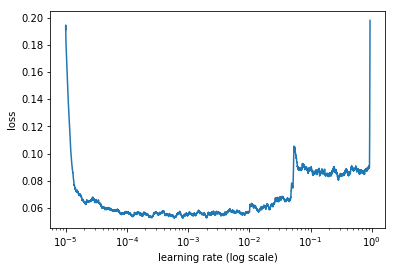

In [14]:
m.sched.plot(n_skip=0, n_skip_end=0)

In [24]:
lr = 0.00015

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# define error term
def rmse(y_pred, targ):
    out = sqrt(mean_squared_error(targ, y_pred))
    return out

In [26]:
m.fit(lrs=lr, n_cycle=3, cycle_len=1, metrics=[rmse])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   rmse                            
    0      0.052095   0.052889   0.229488  
    1      0.052249   0.052841   0.22938                         
    2      0.051214   0.052874   0.229457                        



[array([0.05287]), 0.22945686451361483]

In [27]:
# get final RMSE on holdout data
x,y = m.predict_with_targs()
rmse(x,y)

0.22994400350856303

In [28]:
m.save('val04')

In [ ]:
# df_test = pd.read_csv(f'{PATH}test.csv')

### Submission
Produce expected output format and submit to kaggle

In [29]:
pred_test = m.predict(is_test=True)

In [30]:
df_test_original = pd.read_csv(f'{PATH}test.csv')

In [31]:
# produce output
out = pd.DataFrame(
    data={
        'item_id': df_test_original.item_id,
        'deal_probability': pred_test[:,0]})
# reorder columns
out = out[['item_id','deal_probability']]

In [32]:
out.to_csv('~/avito/out/submission004.csv', index=False)

In [33]:
!head ~/avito/out/submission004.csv

item_id,deal_probability
6544e41a8817,0.055866085
65b9484d670f,0.081489615
8bab230b2ecd,0.054549024
8e348601fefc,0.15958658
8bd2fe400b89,0.12590027
c63dbd6c657f,0.10796416
6d1a410df86e,0.022989979
e8d3e7922b80,0.035282306
2bc1ab208462,0.035701673


In [35]:
!kaggle competitions submit -c avito-demand-prediction -f ~/avito/out/submission004.csv -m ann3_correct-y

Successfully submitted to Avito Demand Prediction Challenge

In [37]:
!kaggle competitions submit -c avito-demand-prediction -f ~/data/avito-demand-prediction/sample_submission.csv -m sample_submission

Successfully submitted to Avito Demand Prediction Challenge